In [2]:
import random
import matplotlib.pyplot as plt

from collections import deque

import pennylane as qml
from pennylane.templates import ApproxTimeEvolution
from pennylane import numpy as np
import itertools


In [299]:
class TSP:
    def __init__(self, number_of_cities, coords_range=(0, 10000)):
        self.number_of_cities = number_of_cities
        self.coords_range = coords_range
        self.cities_coords = self.get_cities()
        self.distance_matrix = self.calculate_distance_matrix()
        self.normalized_distance_matrix = self.normalize_distance_matrix()
    
    def get_cities(self):
        cities_coords = np.random.randint(self.coords_range[0], self.coords_range[1], size = (self.number_of_cities, 2))
        return cities_coords
           
    def normalize_cities(self):
        max_coords = np.amax(self.cities_coords, axis=0)
        normalized_cities_coords = np.divide(self.cities_coords, max_coords)
        return normalized_cities_coords

    def calculate_distance_between_points(self, point_A, point_B):
        return np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2)
    
    def calculate_distance_matrix(self):
        distance_matrix = np.zeros((self.number_of_cities, self.number_of_cities))
        for i in range(self.number_of_cities):
            for j in range(i, self.number_of_cities):
                distance_matrix[i][j] = self.calculate_distance_between_points(self.cities_coords[i], self.cities_coords[j])
                distance_matrix[j][i] = distance_matrix[i][j]
        return distance_matrix 
    
    def normalize_distance_matrix(self):
        return np.divide(self.distance_matrix, np.max(self.distance_matrix))


In [300]:
class QAOA_TSP:
    def __init__(self, tsp_instance, A_1=4, A_2=4, B=1):
        self.tsp_instance = tsp_instance
        self.weights = {'cost_weight': B, 
                        'constraint_each_visited': A_1, 
                        'constraint_each_visited_once': A_2}
        self.cost_operator = self.create_cost_operator()
    
    def calc_bit(self, i, t):
        return i + t * self.tsp_instance.number_of_cities

    def x(self, i, t):
        wire = self.calc_bit(i, t)
        return qml.Hamiltonian([0.5, -0.5], [qml.Identity(wire), qml.PauliZ(wire)])

    def create_cost_operator(self):
        A_1 = self.weights['constraint_each_visited']
        A_2 = self.weights['constraint_each_visited_once']
        B = self.weights['cost_weight']
        
        cost_of_constraint_each_visited = 0    
        for i in range(self.tsp_instance.number_of_cities):
            curr = qml.Identity(0)
            for t in range(self.tsp_instance.number_of_cities):
                curr -= self.x(i, t)    
            for t1 in range(self.tsp_instance.number_of_cities):
                for t2 in range(t1 + 1, self.tsp_instance.number_of_cities):
                    curr += 2 * self.x(i, t1) @ self.x(i, t2)
            cost_of_constraint_each_visited += curr
        cost_of_constraint_each_visited_once = 0
        for t in range(self.tsp_instance.number_of_cities):
            curr = qml.Identity(0)
            for i in range(self.tsp_instance.number_of_cities):
                curr -= self.x(i, t)
            for i1 in range(self.tsp_instance.number_of_cities):
                for i2 in range(i1 + 1, self.tsp_instance.number_of_cities):
                    curr += 2 * self.x(i1, t) @ self.x(i2, t)
            cost_of_constraint_each_visited += curr
        
        cost_of_visiting_cities = 0
        for i, j in itertools.permutations(range(0, self.tsp_instance.number_of_cities), 2):
            curr = qml.Identity(0)
            for t in range(self.tsp_instance.number_of_cities):
                inc_t = t + 1
                if inc_t == self.tsp_instance.number_of_cities:
                    inc_t = 0
                curr += self.x(i, t) @ self.x(j, inc_t)
            cost_of_visiting_cities += float(self.tsp_instance.normalized_distance_matrix[i][j]) * curr 
        
        cost_operator = (
            A_1 * cost_of_constraint_each_visited + 
            A_2 * cost_of_constraint_each_visited_once +
            B * cost_of_visiting_cities
        )
                
        return cost_operator

In [301]:
def hadamard_layer(wires):
    for i in range(wires):
        qml.Hadamard(i)

In [302]:
def create_mixing_hamitonian(wires, const=1/2):
    hamiltonian = qml.Identity(0)
    for i in range(wires):
        hamiltonian += qml.Hamiltonian([const], [qml.PauliX(i)])
    # ApproxTimeEvolution(hamiltonian, time, 1)
    return hamiltonian

In [303]:
n = 3
tsp_instance = TSP(n)
qaoa_tsp = QAOA_TSP(tsp_instance, A_1=4, A_2=4, B=1)

In [304]:
print(tsp_instance.cities_coords)

[[4548 8172]
 [4166 3925]
 [ 613 7322]]


In [305]:
def qaoa_layer(gamma, beta):
    qml.qaoa.cost_layer(gamma, qaoa_tsp.cost_operator)
    qml.qaoa.mixer_layer(beta, create_mixing_hamitonian(n**2))

In [306]:
def circuit(params, n_layers=2):
    hadamard_layer(n**2)
    qml.layer(qaoa_layer, n_layers, params[0], params[1])

In [307]:
dev = qml.device("default.qubit", wires=n**2)


@qml.qnode(dev)
def cost_function(params):
    circuit(params, n_layers=6)
    x = qml.expval(qaoa_tsp.cost_operator)
    return x

In [308]:
# fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")([[0, 0], [0, 0]], knapsack)
# fig.show()
optimizer = qml.AdamOptimizer()
steps = 70
params = np.array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]], requires_grad=True)

/tmp/ipykernel_11901/3773707193.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


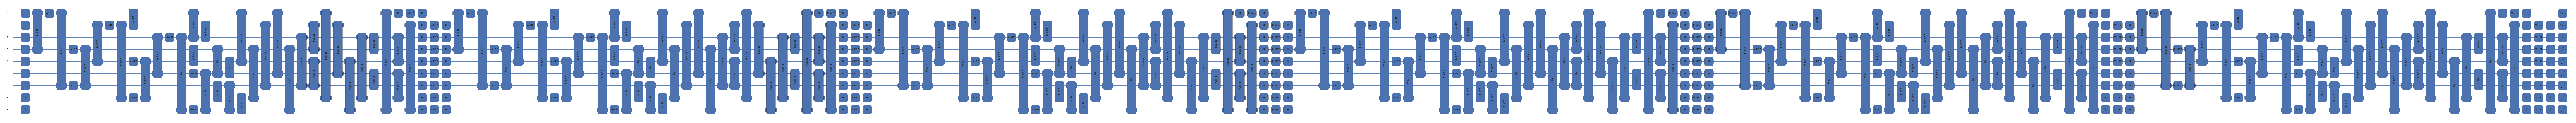

In [309]:
fig, ax = qml.draw_mpl(cost_function, expansion_strategy="device")(params)
fig.show()

In [310]:
for i in range(steps):
    params = optimizer.step(cost_function, params)
    if i % 5 == 0:
        print(params)

print("Optimal Parameters")
print(params)

[[0.49 0.49 0.49 0.49 0.51 0.51]
 [0.51 0.51 0.49 0.51 0.49 0.51]]
[[0.4914246  0.45438651 0.46338629 0.48282096 0.51040549 0.55903432]
 [0.55943501 0.55546063 0.45063888 0.52296166 0.45500286 0.5268931 ]]
[[0.52494517 0.44685209 0.44589047 0.47995136 0.51770415 0.59740755]
 [0.60384152 0.59997311 0.44547063 0.55946159 0.41790274 0.53761928]]
[[0.55341174 0.43387356 0.43976495 0.47013451 0.52033578 0.61186107]
 [0.62449168 0.59566321 0.43934018 0.60283148 0.40489266 0.53324282]]
[[0.56975789 0.40467403 0.4492421  0.46461207 0.51704552 0.60588622]
 [0.63433339 0.55906191 0.4075104  0.6420255  0.40923006 0.51025641]]
[[0.58653211 0.38681639 0.46540099 0.46536748 0.51614173 0.60659493]
 [0.64201598 0.52163455 0.38140811 0.68965776 0.4377643  0.46613138]]
[[0.59698188 0.38314603 0.46273602 0.45983856 0.52848274 0.61806694]
 [0.66305887 0.49437218 0.35465415 0.74108014 0.47731436 0.41488481]]
[[0.60203734 0.37976225 0.45538591 0.46124124 0.53589096 0.61602771]
 [0.68821058 0.47457184 0.3139

In [311]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha], n_layers=6)
    return qml.probs(wires=range(n**2))

probs = probability_circuit(params[0], params[1])

In [312]:
# plt.style.use("seaborn")
# plt.bar(range(2 ** (n_wires)), probs)
# plt.show()
print(probs)

[9.54194989e-03 9.63164929e-04 8.88459904e-04 3.76597652e-04
 1.28384733e-03 1.22987520e-04 2.05276669e-04 2.99216852e-03
 9.63164929e-04 2.38463176e-04 1.83880161e-03 2.65443287e-04
 1.20384926e-03 4.53808892e-04 1.97358352e-03 2.80061580e-04
 8.88459904e-04 1.83880161e-03 3.00777731e-04 2.33431523e-04
 1.31786345e-03 2.56126764e-03 3.52314809e-04 5.15214526e-04
 3.76597652e-04 2.65443287e-04 2.33431523e-04 7.16025604e-04
 1.98194068e-03 3.90733966e-04 4.97858252e-04 3.12383706e-04
 1.28384733e-03 1.20384926e-03 1.31786345e-03 1.98194068e-03
 1.63859921e-04 4.85199422e-04 4.18794615e-04 5.89360583e-05
 1.22987520e-04 4.53808892e-04 2.56126764e-03 3.90733966e-04
 4.85199422e-04 4.94128663e-04 1.47639660e-04 7.46177455e-04
 2.05276669e-04 1.97358352e-03 3.52314809e-04 4.97858252e-04
 4.18794615e-04 1.47639660e-04 5.94036005e-04 6.33448524e-04
 2.99216852e-03 2.80061580e-04 5.15214526e-04 3.12383706e-04
 5.89360583e-05 7.46177455e-04 6.33448524e-04 3.60335646e-04
 9.63164929e-04 2.384631

In [316]:
correct_results_4 = ("0001100001000010","0010010010000001","0100100000010010","1000000100100100","1000010000100001","0100001000011000","0001001001001000","0010000110000100","0100000110000010","0010100000010100","0001010000101000","0001100000100100","1000000101000010","1000001001000001","0100001010000001", "0100000100101000", "0010010000011000", "0100100000100001", "1000001000010100", "0001001010000100", "0001010010000010","0010000101001000", "1000010000010010", "0010100001000001")

correct_results_3 = ("100010001", "100001010", "010100001", "010001100", "001100010", "001010100")
result_dict = {key: float(val) for key, val in enumerate(probs)}
result_dict = dict(sorted(result_dict.items(), key=lambda item: item[1], reverse=True))


In [321]:
get_bin = lambda x, n: format(x, 'b').zfill(n)
for key, val in result_dict.items():
    print(f"Key: {get_bin(key, n**2)} with probability {val}   | correct: {'True' if get_bin(key, n**2) in correct_results_3 else 'False'}")

Key: 100010001 with probability 0.09316905676336623   | correct: True
Key: 010001100 with probability 0.09316905676336618   | correct: True
Key: 100001010 with probability 0.09316905676336618   | correct: True
Key: 001100010 with probability 0.0931690567633661   | correct: True
Key: 001010100 with probability 0.09316905676336606   | correct: True
Key: 010100001 with probability 0.09316905676336593   | correct: True
Key: 101010010 with probability 0.016092880953769765   | correct: False
Key: 010101010 with probability 0.016092880953769755   | correct: False
Key: 010010101 with probability 0.016092880953769737   | correct: False
Key: 110001001 with probability 0.011428086590622017   | correct: False
Key: 001001110 with probability 0.011428086590622014   | correct: False
Key: 001110001 with probability 0.011428086590622   | correct: False
Key: 000000000 with probability 0.009541949886699654   | correct: False
Key: 010001010 with probability 0.006295083184115631   | correct: False
Key: 001

In [ ]:
plt.style.use("seaborn")
plt.bar(range(2 ** (n ** 2)), probs)
plt.show()